In [1]:
import os
import sys
import socket
import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy('file_system')
import warnings

warnings.filterwarnings("ignore")

conf_path = os.getcwd()
sys.path.append(conf_path)
sys.path.append(conf_path + '/datasets')
sys.path.append(conf_path + '/backbone')
sys.path.append(conf_path + '/models')
from datasets import Priv_NAMES as DATASET_NAMES
from models import get_all_models
from argparse import ArgumentParser
from utils.args import add_management_args
from datasets import get_prive_dataset
from models import get_model
from utils.training import train
from utils.best_args import best_args
from utils.conf import set_random_seed
import setproctitle

import torch
import uuid
import datetime

ModuleNotFoundError: No module named 'datasets.'

In [2]:
conf_path

'C:\\Users\\arthu\\USPy\\0_BEPE\\1_FPL'

In [2]:
def parse_args():
    parser = ArgumentParser(description='You Only Need Me', allow_abbrev=False)
    parser.add_argument('--device_id', type=int, default=0, help='The Device Id for Experiment')

    parser.add_argument('--communication_epoch', type=int, default=2, help='The Communication Epoch in Federated Learning')
    parser.add_argument('--local_epoch', type=int, default=3, help='The Local Epoch for each Participant')
    parser.add_argument('--parti_num', type=int, default=3, help='The Number for Participants')

    parser.add_argument('--seed', type=int, default=0, help='The random seed.')
    parser.add_argument('--rand_dataset', type=dict, default={'mnist': 1, 'usps': 1, 'svhn': 1, 'syn': 2}, help='The random seed.')

    parser.add_argument('--model', type=str, default='fpl',  # moon fedinfonce
                        help='Model name.', choices=get_all_models())
    parser.add_argument('--structure', type=str, default='homogeneity')
    parser.add_argument('--dataset', type=str, default='fl_digits',  # fl_officecaltech fl_digits
                        choices=DATASET_NAMES, help='Which scenario to perform experiments on.')

    parser.add_argument('--pri_aug', type=str, default='weak',  # weak strong
                        help='Augmentation for Private Data')
    parser.add_argument('--online_ratio', type=float, default=1, help='The Ratio for Online Clients')
    parser.add_argument('--learning_decay', type=bool, default=False, help='The Option for Learning Rate Decay')
    parser.add_argument('--averaing', type=str, default='weight', help='The Option for averaging strategy')

    parser.add_argument('--infoNCET', type=float, default=0.02, help='The InfoNCE temperature')
    parser.add_argument('--T', type=float, default=0.05, help='The Knowledge distillation temperature')
    parser.add_argument('--weight', type=int, default=1, help='The Wegith for the distillation loss')

    parser.add_argument('--reserv_ratio', type=float, default=0.1, help='Reserve ratio for prototypes')

    torch.set_num_threads(4)
    def add_management_args(parser: ArgumentParser) -> None:
        parser.add_argument('--csv_log', action='store_true',
                            help='Enable csv logging',default=False)
    
    add_management_args(parser)
    
    args, unknown = parser.parse_known_args()

    best = best_args[args.dataset][args.model]

    for key, value in best.items():
        setattr(args, key, value)

    if args.seed is not None:
        set_random_seed(args.seed)
    return args

In [3]:
args = parse_args()

priv_dataset = get_prive_dataset(args)

In [4]:
priv_dataset.train_loaders

[]

In [5]:
print(vars(priv_dataset))

{'train_loaders': [], 'test_loader': [], 'args': Namespace(device_id=0, communication_epoch=2, local_epoch=3, parti_num=3, seed=0, rand_dataset={'mnist': 1, 'usps': 1, 'svhn': 1, 'syn': 2}, model='fpl', structure='homogeneity', dataset='fl_digits', pri_aug='weak', online_ratio=1, learning_decay=False, averaing='weight', infoNCET=0.02, T=0.05, weight=1, reserv_ratio=0.1, csv_log=False, local_lr=0.01, local_batch_size=64, Note='+ MSE')}


In [6]:
backbones_list = priv_dataset.get_backbone(args.parti_num, None)

In [7]:
model = get_model(backbones_list, args, priv_dataset.get_transform())

In [8]:
# print(vars(model))

In [9]:
# model.nets_list[0]

In [10]:
import torch
from argparse import Namespace
from models.utils.federated_model import FederatedModel
from datasets.utils.federated_dataset import FederatedDataset
from typing import Tuple
from torch.utils.data import DataLoader
import numpy as np
from utils.logger import CsvWriter
from collections import Counter


def global_evaluate(model: FederatedModel, test_dl: DataLoader, setting: str, name: str) -> Tuple[list, list]:
    accs = []
    net = model.global_net
    status = net.training
    net.eval()
    for j, dl in enumerate(test_dl):
        correct, total, top1, top5 = 0.0, 0.0, 0.0, 0.0
        for batch_idx, (images, labels) in enumerate(dl):
            with torch.no_grad():
                images, labels = images.to(model.device), labels.to(model.device)
                outputs = net(images)
                _, max5 = torch.topk(outputs, 5, dim=-1)
                labels = labels.view(-1, 1)
                top1 += (labels == max5[:, 0:1]).sum().item()
                top5 += (labels == max5).sum().item()
                total += labels.size(0)
        top1acc = round(100 * top1 / total, 2)
        top5acc = round(100 * top5 / total, 2)
        # if name in ['fl_digits','fl_officecaltech']:
        accs.append(top1acc)
        # elif name in ['fl_office31','fl_officehome']:
        #     accs.append(top5acc)
    net.train(status)
    return accs


def train(model: FederatedModel, private_dataset: FederatedDataset, args: Namespace) -> None:
    if args.csv_log:
        csv_writer = CsvWriter(args, private_dataset)

    model.N_CLASS = private_dataset.N_CLASS
    domains_list = private_dataset.DOMAINS_LIST
    domains_len = len(domains_list)

    if args.rand_dataset:
        max_num = 10
        is_ok = False

        while not is_ok:
            if model.args.dataset == 'fl_officecaltech':
                selected_domain_list = np.random.choice(domains_list, size=args.parti_num - domains_len, replace=True, p=None)
                selected_domain_list = list(selected_domain_list) + domains_list
            elif model.args.dataset == 'fl_digits':
                selected_domain_list = np.random.choice(domains_list, size=args.parti_num, replace=True, p=None)

            result = dict(Counter(selected_domain_list))

            for k in result:
                if result[k] > max_num:
                    is_ok = False
                    break
            else:
                is_ok = True
    else:
        selected_domain_dict = {'mnist': 6, 'usps': 4, 'svhn': 3, 'syn': 7}  # base
        selected_domain_dict = {'mnist': 3, 'usps': 7, 'svhn': 6, 'syn': 4}  # article

        # selected_domain_dict = {'mnist': 1, 'usps': 1, 'svhn': 9, 'syn': 9}  # 20

        # selected_domain_dict = {'mnist': 3, 'usps': 2, 'svhn': 1, 'syn': 4}  # 10

        selected_domain_list = []
        for k in selected_domain_dict:
            domain_num = selected_domain_dict[k]
            for i in range(domain_num):
                selected_domain_list.append(k)

        selected_domain_list = np.random.permutation(selected_domain_list)

        result = Counter(selected_domain_list)
    print(result)

    print(selected_domain_list)
    pri_train_loaders, test_loaders, label_dict = private_dataset.get_data_loaders(selected_domain_list)
    model.trainloaders = pri_train_loaders
    if hasattr(model, 'ini'):
        model.ini()

    accs_dict = {}
    mean_accs_list = []

    Epoch = args.communication_epoch
    for epoch_index in range(Epoch):
        model.epoch_index = epoch_index
        if hasattr(model, 'loc_update'):
            epoch_loc_loss_dict = model.loc_update(pri_train_loaders)

        accs = global_evaluate(model, test_loaders, private_dataset.SETTING, private_dataset.NAME)
        mean_acc = round(np.mean(accs, axis=0), 3)
        mean_accs_list.append(mean_acc)
        for i in range(len(accs)):
            if i in accs_dict:
                accs_dict[i].append(accs[i])
            else:
                accs_dict[i] = [accs[i]]

        print('The ' + str(epoch_index) + ' Communcation Accuracy:', str(mean_acc), 'Method:', model.args.model)
        print(accs)

    if args.csv_log:
        csv_writer.write_acc(accs_dict, mean_accs_list)
        
    return label_dict


In [ ]:
The 49 Communcation Accuracy: 74.34 Method: fpl
[97.63, 88.94, 68.75, 42.04]

batch 256

The 49 Communcation Accuracy: 80.12 Method: fpl
[98.08, 90.33, 79.53, 52.54]
batch 64

In [ ]:
label_dict = train(model, priv_dataset, args)

{'mnist': 1, 'syn': 1, 'usps': 1}
['mnist' 'syn' 'usps']


Local Pariticipant 2 CE = 2.197,InfoNCE = 0.000: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
The 0 Communcation Accuracy: 13.51 Method: fpl
[11.35, 13.15, 19.59, 9.95]


Local Pariticipant 2 CE = 1.569,InfoNCE = 1.627: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters
Partition 0: 1 clusters


In [13]:
label_dict.keys()

dict_keys(['mnist', 'syn', 'usps'])

In [15]:
for d in label_dict.values():
    print(len(d))

60000
10000
7291


In [ ]:
label_indices = {}
for index, label in enumerate(d):
    if label not in label_indices:
        label_indices[label] = []
    label_indices[label].append(index)

sorted_mapping = dict(sorted(label_indices.items()))
sorted_mapping

In [10]:
model.trainloaders

In [12]:
loader = model.trainloaders[2]
print(loader.dataset)
print(loader.batch_size) 

aux_size = 0
for batch in loader:
    print(batch[1].shape)
    aux_size += len(batch[1])
    
print(aux_size)

Dataset USPS
    Number of datapoints: 7291
    Root location: C:/Users/arthu/USPy/0_BEPE/1_FPL/datasets/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
64
torch.Size([64])
torch.Size([8])
72


In [13]:
len(df)

5

In [14]:
df[0]

In [37]:
for i, loader in enumerate(model.trainloaders):
    print(f"DataLoader {i}: {type(loader)}, dataset size: {len(loader.dataset)}")

DataLoader 0: <class 'torch.utils.data.dataloader.DataLoader'>, dataset size: 60000
DataLoader 1: <class 'torch.utils.data.dataloader.DataLoader'>, dataset size: 10000
DataLoader 2: <class 'torch.utils.data.dataloader.DataLoader'>, dataset size: 7291
DataLoader 3: <class 'torch.utils.data.dataloader.DataLoader'>, dataset size: 60000
DataLoader 4: <class 'torch.utils.data.dataloader.DataLoader'>, dataset size: 10000


In [112]:
all_indexes = {}

for i, loader in enumerate(model.trainloaders):
    sampler = loader.sampler
    
    # Get index order (works for both shuffled and unshuffled loaders)
    if hasattr(sampler, 'indices'):
        indexes = sampler.indices  # Direct access if available
    else:
        indexes = list(sampler)  # Convert sampler to list

    all_indexes[i] = indexes

# Print first 10 indices for each DataLoader
for name, indexes in all_indexes.items():
    print(f"{name}: {len(indexes)} {indexes[:10]}")

0: 600 [42286 31361  7025  2032   470  2581  5203 39356 58719 39919]
1: 100 [4298 2349 2017 7766 2456 3238  388 9609 9278 2889]
2: 72 [ 922 4732 7082 2082 6266 6743 1720 6186 2764 3324]
3: 600 [11857 58590 53722 22560 59543  1319 58033 15771 45315 46918]
4: 100 [7532 4438 2603 4137 8586 3670  934 6744 5192 6863]


In [116]:
shared_elements = set(all_indexes[0]).intersection(set(all_indexes[3]))

if shared_elements:
    print("The lists share elements:", shared_elements)
else:
    print("The lists do not share any elements.")

The lists do not share any elements.


600

In [119]:
for i, loader in enumerate(model.trainloaders):
    print(f"Inspecting DataLoader {i}")
    for batch_idx, (inputs, labels) in enumerate(loader):
        print(f"Batch {batch_idx}: Labels {labels}")
    break  # If you want to inspect only the first DataLoader, otherwise remove this


Inspecting DataLoader 0
Batch 0: Labels tensor([3, 2, 4, 5, 6, 2, 6, 0, 2, 0, 7, 4, 0, 2, 4, 8, 2, 7, 7, 8, 4, 9, 9, 5,
        2, 7, 8, 6, 9, 7, 0, 0, 0, 4, 3, 9, 4, 2, 7, 0, 7, 6, 4, 6, 6, 8, 5, 1,
        9, 8, 6, 1, 2, 7, 7, 6, 4, 8, 8, 9, 8, 3, 7, 4])
Batch 1: Labels tensor([3, 3, 0, 1, 7, 6, 4, 0, 2, 2, 5, 5, 7, 2, 3, 6, 9, 9, 8, 3, 2, 8, 9, 4,
        8, 2, 6, 0, 3, 2, 7, 4, 0, 5, 2, 3, 6, 2, 8, 0, 5, 6, 1, 5, 0, 1, 1, 3,
        1, 6, 0, 4, 0, 0, 1, 1, 1, 7, 7, 1, 7, 8, 1, 9])
Batch 2: Labels tensor([1, 9, 4, 9, 7, 3, 2, 9, 4, 4, 8, 8, 4, 0, 3, 4, 9, 4, 8, 3, 1, 3, 3, 2,
        2, 6, 0, 4, 2, 4, 6, 3, 6, 7, 8, 6, 9, 1, 0, 8, 3, 3, 5, 2, 5, 7, 1, 7,
        8, 0, 9, 8, 7, 9, 7, 8, 8, 7, 7, 3, 3, 2, 6, 9])
Batch 3: Labels tensor([1, 2, 3, 0, 9, 9, 5, 2, 4, 6, 8, 7, 5, 8, 3, 1, 4, 7, 3, 4, 5, 4, 5, 1,
        3, 7, 3, 6, 6, 7, 1, 1, 8, 4, 9, 9, 7, 2, 9, 4, 5, 4, 6, 7, 9, 6, 1, 2,
        5, 9, 2, 6, 8, 0, 1, 5, 3, 5, 8, 1, 0, 9, 8, 3])
Batch 4: Labels tensor([3, 0, 8, 8, 8, 2, 8,

In [120]:
import torch
from collections import Counter, OrderedDict

# Store the count of labels for each batch
batch_label_counts = []

# Iterate over the loader
print(f"Inspecting DataLoader {i}")
for batch_idx, (inputs, labels) in enumerate(loader):
    # Count the occurrences of each label in this batch
    label_count = Counter(labels.tolist())  # Convert tensor to list and count
    
    # Sort the dictionary by the label (key) and store it as an OrderedDict
    sorted_label_count = OrderedDict(sorted(label_count.items()))
    
    batch_label_counts.append(sorted_label_count)

# Display the results
for batch_idx, label_count in enumerate(batch_label_counts):
    print(f"Batch {batch_idx} label counts: {label_count}")

Inspecting DataLoader 0
Batch 0 label counts: OrderedDict([(0, 10), (1, 3), (2, 3), (3, 7), (4, 7), (5, 7), (6, 8), (7, 5), (8, 4), (9, 10)])
Batch 1 label counts: OrderedDict([(0, 8), (1, 6), (2, 8), (3, 10), (4, 6), (5, 7), (6, 4), (7, 5), (8, 5), (9, 5)])
Batch 2 label counts: OrderedDict([(0, 7), (1, 9), (2, 6), (3, 7), (4, 6), (5, 5), (6, 10), (7, 2), (8, 3), (9, 9)])
Batch 3 label counts: OrderedDict([(0, 2), (1, 7), (2, 2), (3, 12), (4, 8), (5, 9), (6, 10), (7, 5), (8, 2), (9, 7)])
Batch 4 label counts: OrderedDict([(0, 8), (1, 1), (2, 8), (3, 4), (4, 5), (5, 5), (6, 6), (7, 7), (8, 11), (9, 9)])
Batch 5 label counts: OrderedDict([(0, 7), (1, 3), (2, 11), (3, 4), (4, 7), (5, 6), (6, 9), (7, 8), (8, 3), (9, 6)])
Batch 6 label counts: OrderedDict([(0, 5), (1, 4), (2, 6), (3, 4), (4, 5), (5, 9), (6, 7), (7, 8), (8, 7), (9, 9)])
Batch 7 label counts: OrderedDict([(0, 5), (1, 10), (2, 6), (3, 5), (4, 3), (5, 4), (6, 7), (7, 8), (8, 9), (9, 7)])
Batch 8 label counts: OrderedDict([(0, 

DataLoader_0: [42286 31361  7025  2032   470  2581  5203 39356 58719 39919]
DataLoader_1: [4298 2349 2017 7766 2456 3238  388 9609 9278 2889]
DataLoader_2: [ 922 4732 7082 2082 6266 6743 1720 6186 2764 3324]
DataLoader_3: [11857 58590 53722 22560 59543  1319 58033 15771 45315 46918]
DataLoader_4: [7532 4438 2603 4137 8586 3670  934 6744 5192 6863]
Batch 0 label counts: OrderedDict([('0', 9), ('1', 5), ('2', 5), ('3', 6), ('4', 6), ('5', 5), ('6', 4), ('7', 8), ('8', 7), ('9', 9)])
Batch 1 label counts: OrderedDict([('0', 5), ('1', 8), ('2', 6), ('3', 10), ('4', 2), ('5', 6), ('6', 8), ('7', 6), ('8', 5), ('9', 8)])
Batch 2 label counts: OrderedDict([('0', 4), ('1', 3), ('2', 6), ('3', 5), ('4', 4), ('5', 10), ('6', 6), ('7', 9), ('8', 8), ('9', 9)])
Batch 3 label counts: OrderedDict([('0', 7), ('1', 2), ('2', 7), ('3', 2), ('4', 9), ('5', 7), ('6', 9), ('7', 8), ('8', 7), ('9', 6)])
Batch 4 label counts: OrderedDict([('0', 7), ('1', 6), ('2', 7), ('3', 9), ('4', 5), ('5', 8), ('6', 7),

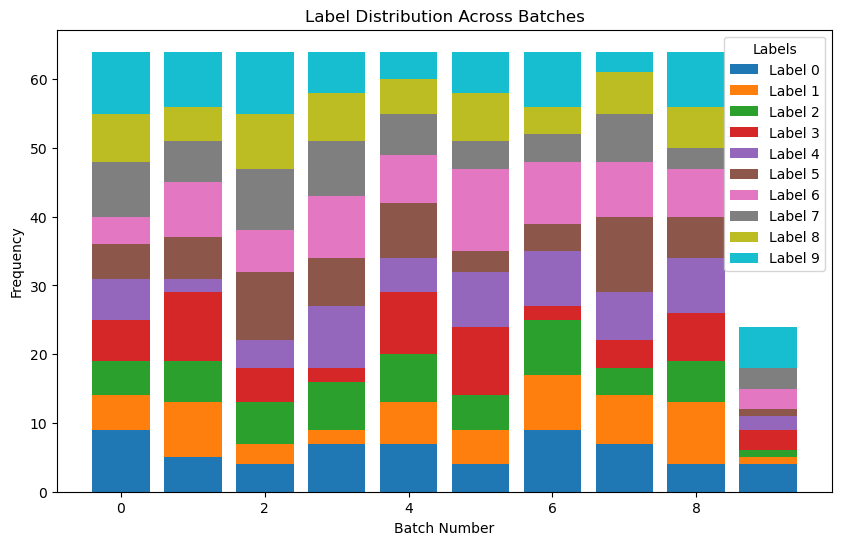

Batch 0 label counts: OrderedDict([('0', 3), ('1', 2), ('2', 8), ('3', 3), ('4', 9), ('5', 8), ('6', 10), ('7', 7), ('8', 5), ('9', 9)])
Batch 1 label counts: OrderedDict([('0', 2), ('1', 3), ('2', 7), ('3', 6), ('4', 5), ('5', 1), ('6', 4), ('7', 4), ('8', 2), ('9', 2)])


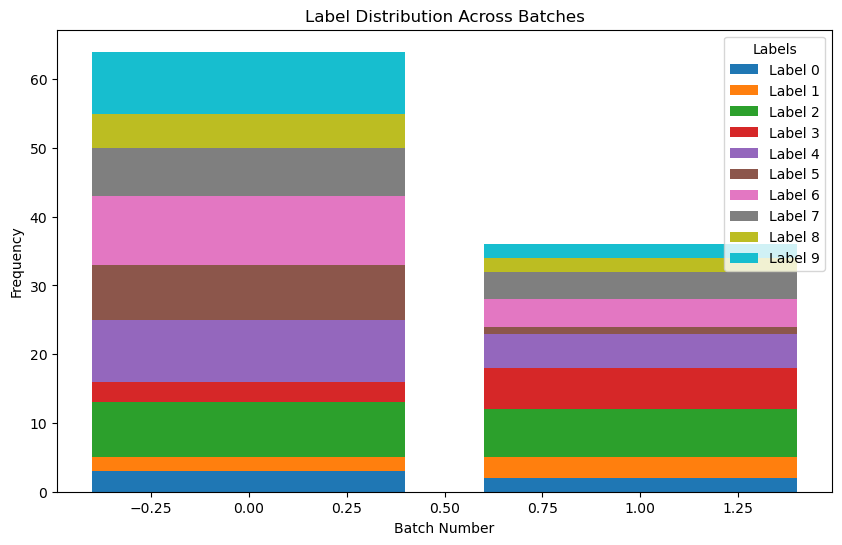

Batch 0 label counts: OrderedDict([('0', 13), ('1', 9), ('2', 6), ('3', 6), ('4', 6), ('5', 4), ('6', 5), ('7', 9), ('8', 3), ('9', 3)])
Batch 1 label counts: OrderedDict([('0', 2), ('1', 0), ('2', 0), ('3', 1), ('4', 2), ('5', 1), ('6', 0), ('7', 1), ('8', 1), ('9', 0)])


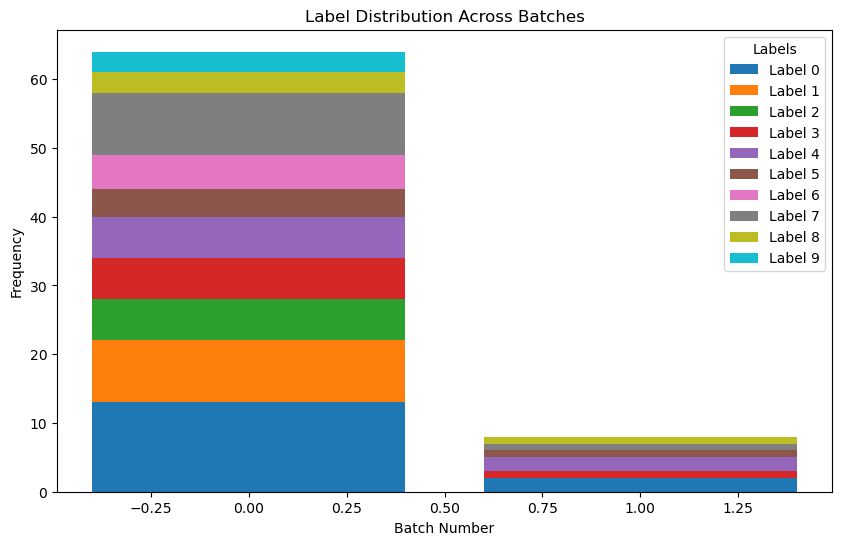

Batch 0 label counts: OrderedDict([('0', 9), ('1', 11), ('2', 4), ('3', 3), ('4', 9), ('5', 5), ('6', 5), ('7', 7), ('8', 9), ('9', 2)])
Batch 1 label counts: OrderedDict([('0', 6), ('1', 9), ('2', 4), ('3', 3), ('4', 9), ('5', 5), ('6', 3), ('7', 12), ('8', 7), ('9', 6)])
Batch 2 label counts: OrderedDict([('0', 7), ('1', 7), ('2', 9), ('3', 7), ('4', 6), ('5', 3), ('6', 8), ('7', 5), ('8', 8), ('9', 4)])
Batch 3 label counts: OrderedDict([('0', 3), ('1', 5), ('2', 7), ('3', 11), ('4', 7), ('5', 7), ('6', 6), ('7', 5), ('8', 5), ('9', 8)])
Batch 4 label counts: OrderedDict([('0', 7), ('1', 7), ('2', 4), ('3', 6), ('4', 3), ('5', 6), ('6', 14), ('7', 6), ('8', 6), ('9', 5)])
Batch 5 label counts: OrderedDict([('0', 7), ('1', 10), ('2', 3), ('3', 7), ('4', 3), ('5', 9), ('6', 8), ('7', 8), ('8', 6), ('9', 3)])
Batch 6 label counts: OrderedDict([('0', 6), ('1', 3), ('2', 6), ('3', 8), ('4', 5), ('5', 9), ('6', 8), ('7', 8), ('8', 6), ('9', 5)])
Batch 7 label counts: OrderedDict([('0', 4)

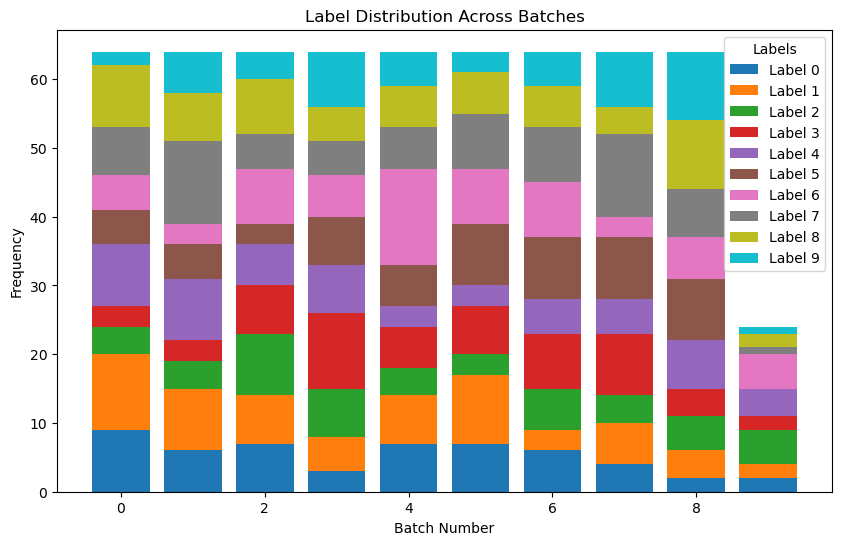

Batch 0 label counts: OrderedDict([('0', 3), ('1', 7), ('2', 7), ('3', 4), ('4', 7), ('5', 2), ('6', 7), ('7', 8), ('8', 9), ('9', 10)])
Batch 1 label counts: OrderedDict([('0', 4), ('1', 5), ('2', 2), ('3', 5), ('4', 4), ('5', 5), ('6', 1), ('7', 1), ('8', 7), ('9', 2)])


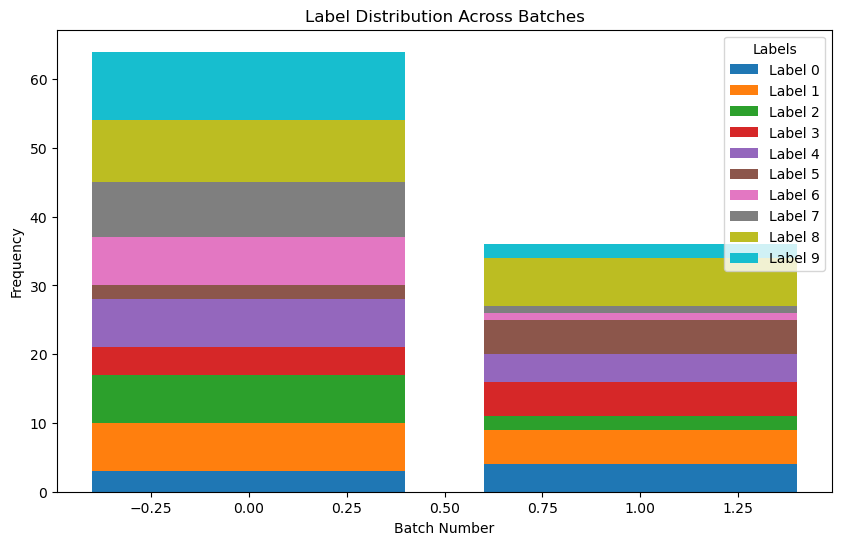

In [123]:
import torch
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

def inspect_dataloader(model):
    """
    Inspects the provided DataLoaders from the model to summarize label counts across batches,
    and visualizes the distribution of labels in a stacked bar plot. It also retrieves
    the dataset indexes from each DataLoader.
    
    Args:
    - model: The model object containing the DataLoaders to inspect.
    
    Returns:
    - dict: A dictionary where keys are DataLoader names (e.g., 'DataLoader_0')
            and values are the corresponding list of dataset indexes.
    """
    all_indexes = {}  # Dictionary to store indexes for each DataLoader

    # Iterate through each DataLoader in the model
    for i, loader in enumerate(model.trainloaders):
        sampler = loader.sampler
        
        # Get index order (works for both shuffled and unshuffled loaders)
        if hasattr(sampler, 'indices'):
            indexes = sampler.indices  # Direct access if available
        else:
            indexes = list(sampler)  # Convert sampler to list

        all_indexes[f"DataLoader_{i}"] = indexes

    # Print first 10 indices for each DataLoader
    for name, indexes in all_indexes.items():
        print(f"{name}: {indexes[:10]}")

    # Store the count of labels for each batch
    batch_label_counts = []
    for loader in model.trainloaders:
        # Visualize label distribution across batches
        label_frequencies = []

        for batch_idx, (inputs, labels) in enumerate(loader):
            label_count = OrderedDict((str(i), 0) for i in range(10))
            
            # Count occurrences of each label in the batch
            for label in labels.numpy():
                label_count[str(label)] += 1
            
            # Append the label counts to the list of frequencies
            label_frequencies.append(list(label_count.values()))

            # Print the label count for this batch (for debugging)
            print(f"Batch {batch_idx} label counts: {label_count}")

        # Convert label_frequencies to a numpy array
        label_frequencies = np.array(label_frequencies)

        # Plot the stacked bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        bottom = np.zeros(len(label_frequencies))  # Initialize bottom position for stacking
        for i in range(10):  # For each label
            ax.bar(np.arange(len(label_frequencies)), label_frequencies[:, i], 
                   bottom=bottom, label=f"Label {i}")
            bottom += label_frequencies[:, i]  # Update bottom for stacking

        # Set plot labels and title
        ax.set_title("Label Distribution Across Batches")
        ax.set_xlabel("Batch Number")
        ax.set_ylabel("Frequency")
        ax.legend(title="Labels")
        
        # Show the plot
        plt.show()

    return all_indexes

# Example usage with model containing trainloaders
all_indexes = inspect_dataloader(model)

DataLoader_0 indexes: [42286 31361  7025  2032   470  2581  5203 39356 58719 39919]


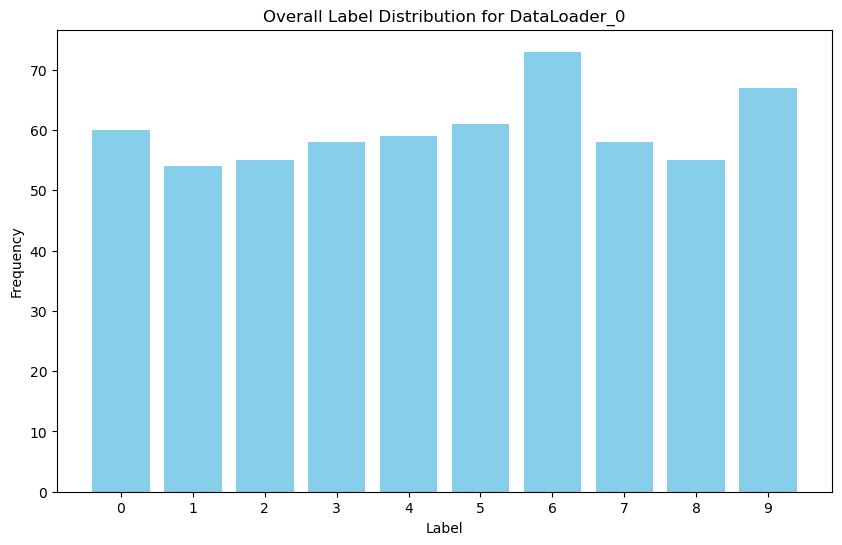

In [125]:
import torch
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np

def inspect_dataloader(model, data_loader_id):
    """
    Inspects the provided DataLoader from the model to summarize label counts across batches,
    and visualizes the overall label distribution across all batches in a single plot. 
    Also retrieves the dataset indexes from the selected DataLoader.
    
    Args:
    - model: The model object containing the DataLoaders to inspect.
    - data_loader_id: The ID of the DataLoader to inspect (e.g., 0 for the first DataLoader).
    
    Returns:
    - dict: A dictionary where keys are DataLoader names (e.g., 'DataLoader_0')
            and values are the corresponding list of dataset indexes.
    """
    all_indexes = {}  # Dictionary to store indexes for each DataLoader

    # Get the selected DataLoader from the model
    loader = model.trainloaders[data_loader_id]
    sampler = loader.sampler
    
    # Get index order (works for both shuffled and unshuffled loaders)
    if hasattr(sampler, 'indices'):
        indexes = sampler.indices  # Direct access if available
    else:
        indexes = list(sampler)  # Convert sampler to list

    all_indexes[f"DataLoader_{data_loader_id}"] = indexes

    # Print first 10 indices for the selected DataLoader
    print(f"DataLoader_{data_loader_id} indexes: {indexes[:10]}")

    # Initialize a list to store the labels across all batches for the selected DataLoader
    all_labels = []

    # Iterate through the DataLoader to collect the labels
    for inputs, labels in loader:
        all_labels.extend(labels.numpy())  # Append the labels to the list

    # Count the occurrences of each label
    label_count = Counter(all_labels)
    
    # Prepare label names and frequencies for plotting
    label_names = [str(i) for i in range(10)]
    label_frequencies = [label_count.get(i, 0) for i in range(10)]

    # Plot the overall label distribution across all batches
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(label_names, label_frequencies, color='skyblue')

    # Set plot labels and title
    ax.set_title(f"Overall Label Distribution for DataLoader_{data_loader_id}")
    ax.set_xlabel("Label")
    ax.set_ylabel("Frequency")
    
    # Show the plot
    plt.show()

    return all_indexes

# Example usage with model containing trainloaders
all_indexes = inspect_dataloader(model, data_loader_id=0)

DataLoader_3 indexes: [11857 58590 53722 22560 59543  1319 58033 15771 45315 46918]


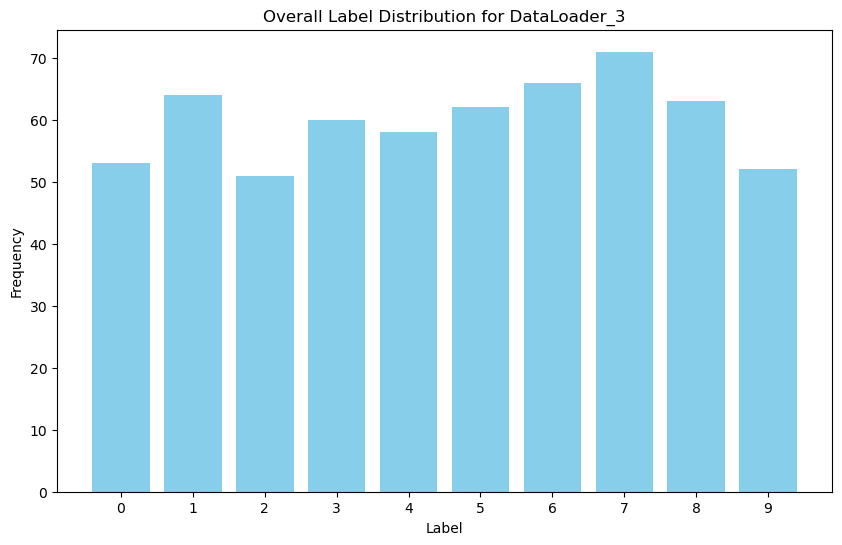

In [126]:
all_indexes = inspect_dataloader(model, data_loader_id=3)